# Cascaded Tanks Incremental Update

The purpose of this note book is to break the ingestion of data from the experiment into multiple updates of the model.  Currently, the issue that is being ran into is that when making predictions in the future, there are points (near data point 1800) where the error is just so large that the input space (which is changing since it is dependant on the integration) goes beyond the training data, including adding a pillow of 50% in the positive direction, when training on the first 1000 data points. This creates some issues with the model as a whole since we can't get predictions, we can't get an RSME either.  So, I trained on the last 1000 data points since it had a better wholistic representation of the data, but this is an error that needs to be explored further.

## Part 1: Preprocessing Data

This is the same as in the first notebook.

In [1]:
# Import relevant libraries

# Data Processing
import pandas as pd
import numpy as np

# Modeling
from FoKL import FoKLRoutines

# Visualizations
import matplotlib.pyplot as plt

# Integration
import scipy
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

In [2]:
# Function for processing .mat files into pandas data frames

def mat_to_dataframe(file_path):
    # Load the .mat file
    mat_data = scipy.io.loadmat(file_path)
    
    # Extract the 'u' and 'y' arrays
    u = mat_data['u'].flatten()
    y = mat_data['y']
    
    # Create a DataFrame
    df = pd.DataFrame({
        'u': u,
        'h1': y[0],
        'h2': y[1] if y.shape[0] > 1 else None
    })
    
    # Add a time index
    df.index = pd.RangeIndex(start=0, stop=len(df), name='Time')
    
    return df

# Load in data
tank1 = mat_to_dataframe('CascadedTanksFiles\Tank1.mat')

# Create a time column (in seconds) based on the time step
time_step_tank1 = 5
tank1['time'] = np.arange(0, len(tank1) * time_step_tank1, time_step_tank1)

tank1

,u,h1,h2,time
Time,,,,
0,0.859640,0.380859,0.205078,0
1,0.859640,0.385742,0.576172,5
2,0.859640,0.405273,0.717773,10
3,0.859640,0.454102,0.849609,15
4,0.859640,0.517578,0.976562,20
...,...,...,...,...
2495,0.640136,1.933594,1.987305,12475
2496,0.640136,1.914062,1.977539,12480
2497,0.640136,1.899414,1.977539,12485


Lastly, let's calculate the values of the derivatives of the heights of the tanks with respect to time.  This will be done with a simple finite differences approximation using the constant time steps using the current data point and the next one (forward differences).

In [3]:
# Function to calculate derivative (assumes constant time)
def calculate_derivative(series, time_step):
    return np.gradient(series, time_step)

# Add derivative columns
# 5 second time step for first data set, u changes every 30 seconds
tank1['h1_der'] = calculate_derivative(series = tank1['h1'], time_step = time_step_tank1)
tank1['h2_der'] = calculate_derivative(series = tank1['h2'], time_step = time_step_tank1)

tank1

,u,h1,h2,time,h1_der,h2_der
Time,,,,,,
0,0.859640,0.380859,0.205078,0,0.000977,0.074219
1,0.859640,0.385742,0.576172,5,0.002441,0.051270
2,0.859640,0.405273,0.717773,10,0.006836,0.027344
3,0.859640,0.454102,0.849609,15,0.011230,0.025879
4,0.859640,0.517578,0.976562,20,0.012695,0.022949
...,...,...,...,...,...,...
2495,0.640136,1.933594,1.987305,12475,-0.003418,-0.001953
2496,0.640136,1.914062,1.977539,12480,-0.003418,-0.000977
2497,0.640136,1.899414,1.977539,12485,-0.002930,-0.000488


Now, let's visualize the data, both the raw values and the derivatives.

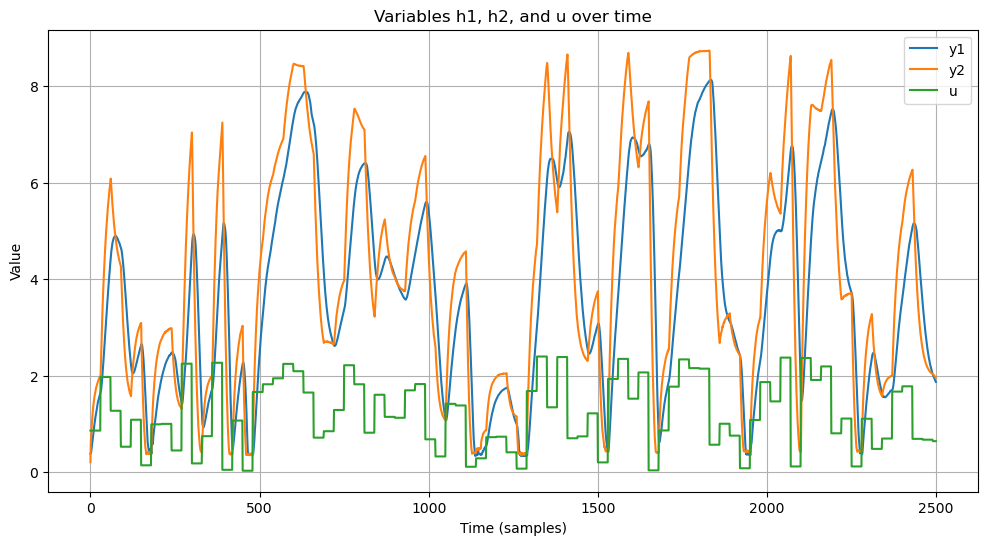

In [4]:
# Assuming your DataFrame is named 'df' and has columns 'y1', 'y2', and 'u'
tank1[['h1', 'h2', 'u']].plot(figsize=(12, 6))

plt.title('Variables h1, h2, and u over time')
plt.xlabel('Time (samples)')
plt.ylabel('Value')
plt.legend(['y1', 'y2', 'u'])
plt.grid(True)


plt.show()

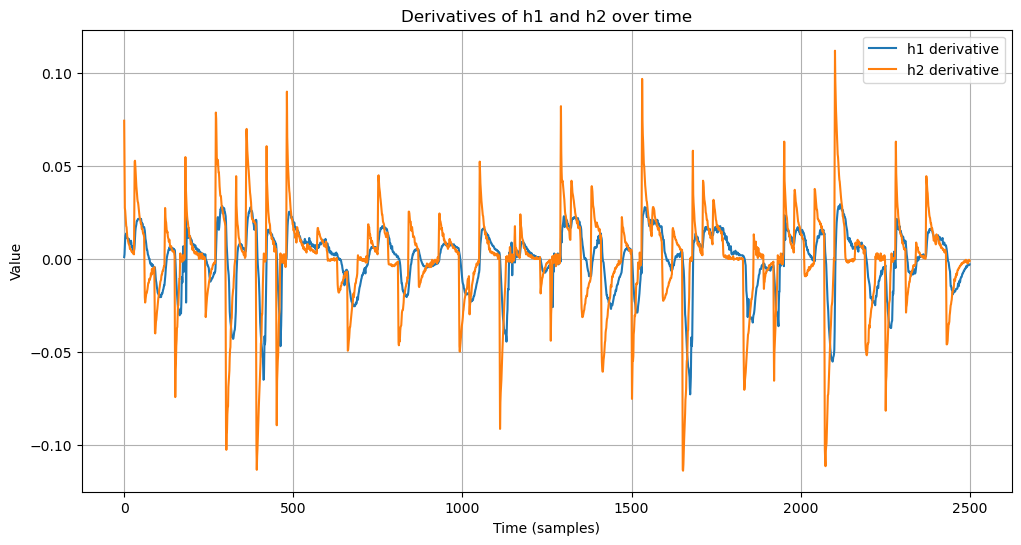

In [5]:
tank1[['h1_der', 'h2_der']].plot(figsize=(12, 6))

plt.title('Derivatives of h1 and h2 over time')
plt.xlabel('Time (samples)')
plt.ylabel('Value')
plt.legend(['h1 derivative', 'h2 derivative'])
plt.grid(True)

plt.show()

## Part 2: Modeling
For this part, we are training on the last 1000 data points since the first 1000 gave issues.

In [6]:
# Create Models for the derivatives of h1 and h2

GP_dh1_model1 = FoKLRoutines.FoKL(UserWarnings=False, draws = 500, tolerance = 1)
GP_dh1_model1.update = True # To use update methodology, must be called PRIOR to first fitting
GP_dh1_model1.built = False # Defines whether fresh model is created or prior model used
_ = GP_dh1_model1.fit(inputs = [tank1[['h1','h2','u']].iloc[:1000]], 
           data = tank1['h1_der'].iloc[:1000], 
           clean = True,
           minmax = [[0,10],[0,10],[0,3]]) 

GP_dh2_model1 = FoKLRoutines.FoKL(UserWarnings=False, draws = 500, tolerance = 1)
GP_dh2_model1.update = True # To use update methodology, must be called PRIOR to first fitting
GP_dh2_model1.built = False # Defines whether fresh model is created or prior model used
_ = GP_dh2_model1.fit(inputs = [tank1[['h1','h2','u']].iloc[:1000]], 
           data = tank1['h2_der'].iloc[:1000], 
           clean = True,
           minmax = [[0,10],[0,10],[0,3]])

1 -9144.076288837445
2 -9494.22871747209
2 -9710.043618873466
3 -9954.249442481636
3 -10099.089606220145
4 -10104.474418080992
4 -10083.152828094653
4 -10062.555652444338
1 -8467.737228814225
2 -8780.103933107139
2 -8904.90892818177
3 -9350.042884473067
3 -9484.507547054925
4 -9504.13648319534
4 -9535.033118500276
4 -9620.577000700596
5 -9581.80910085302
5 -9648.393621826242
5 -9684.89590082449
6 -9661.0029771986
6 -9647.768931271865


Now, as a sanity check, let's visually look at our model predictions compared to our data.

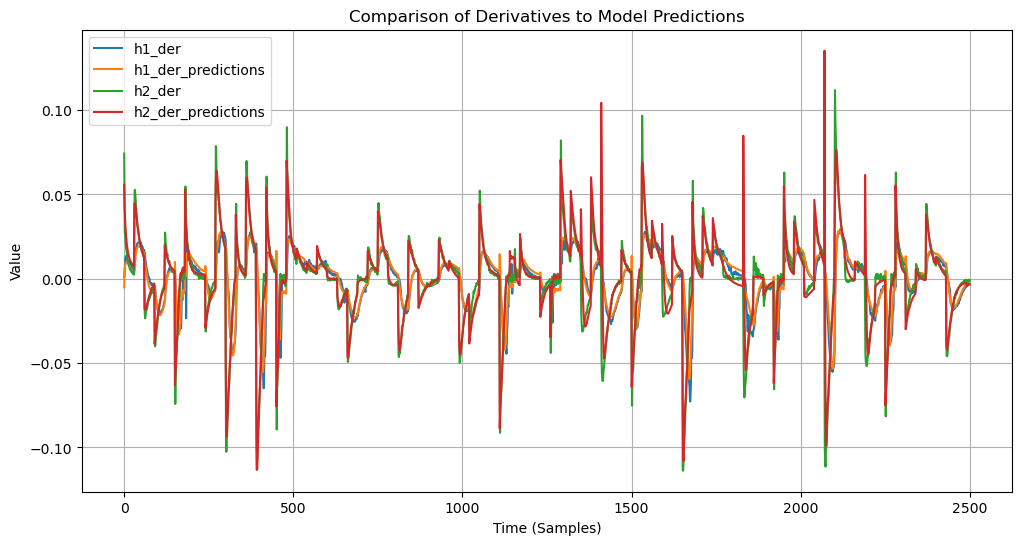

In [7]:
# Predictions based on data
tank1['h1_der_predictions'] = GP_dh1_model1.evaluate(inputs = tank1[['h1','h2','u']], 
                                              clean = True)
tank1['h2_der_predictions'] = GP_dh2_model1.evaluate(inputs = tank1[['h1','h2','u']], 
                                              clean = True)

# Create Plot
tank1[['h1_der', 'h1_der_predictions', 'h2_der', 'h2_der_predictions']].plot(figsize=(12, 6))

plt.title('Comparison of Derivatives to Model Predictions')
plt.xlabel('Time (Samples)')
plt.ylabel('Value')
plt.legend(['h1_der', 'h1_der_predictions', 'h2_der', 'h2_der_predictions'])
plt.grid(True)

plt.show()

## Part 3: Integration of Models
Now, let's integrate to see how this model performs when it is only trained on part of the data set.

In [8]:
# # Create a linear interpolation from our pump input signal for our function
# u_t = interp1d(tank1['time'], tank1['u'])

# # Create ODE function for the heights of the tanks
# def dy_GP(t, y):
#     """ODE to integrate GP of derivative."""
#     return [GP_dh1_model1.evaluate([y[0], y[1], u_t(t)], clean=True, SingleInstance=True)[0], 
#             GP_dh2_model1.evaluate([y[0], y[1], u_t(t)], clean=True, SingleInstance=True)[0]]

# # Integrate
# solution = solve_ivp(fun = dy_GP, 
#                      t_span = [tank1['time'].values[0], tank1['time'].values[-1]], # Time Range
#                      y0 = [tank1['h1'].values[0], tank1['h2'].values[0]], # Initial Conditions
#                      method = 'LSODA', 
#                      t_eval = tank1['time'])
                     
# tank1['h1_prediction_LSODA'] = solution.y[0]
# tank1['h2_prediction_LSODA'] = solution.y[1]
# tank1

Now, let's use the forward Euler's method (Code from Jacob Krell).

In [9]:
# Create vector of times and pump signals
tvec = tank1["time"].values
u = tank1['u'].values
# Create blank vectors for h1 and h2 values
h1 = np.zeros_like(tvec, dtype=float)
h2 = np.zeros_like(tvec, dtype=float)

# Initial Conditions
h1[0] = tank1["h1"].values[0]
h2[0] = tank1["h2"].values[0]
# Integration using forward Euler
for i in range(len(tvec) - 1):
    h1[i] = np.clip(h1[i], GP_dh1_model1.minmax[0][0], GP_dh1_model1.minmax[0][1])
    h2[i] = np.clip(h2[i], GP_dh1_model1.minmax[1][0], GP_dh1_model1.minmax[1][1])
    h1[i + 1] = h1[i] + 5 * GP_dh1_model1.evaluate([h1[i], h2[i], u[i]], clean=True, SingleInstance=True)
    h2[i + 1] = h2[i] + 5 * GP_dh2_model1.evaluate([h1[i], h2[i], u[i]], clean=True, SingleInstance=True)
    
    if i % 250 == 0:
        print(i)

tank1['h1_prediction_Euler'] = h1
tank1['h2_prediction_Euler'] = h2

C:\Users\Michael\AppData\Local\Temp\ipykernel_21692\3283254062.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  h1[i + 1] = h1[i] + 5 * GP_dh1_model1.evaluate([h1[i], h2[i], u[i]], clean=True, SingleInstance=True)
C:\Users\Michael\AppData\Local\Temp\ipykernel_21692\3283254062.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  h2[i + 1] = h2[i] + 5 * GP_dh2_model1.evaluate([h1[i], h2[i], u[i]], clean=True, SingleInstance=True)


0
250
500
750
1000
1250
1500
1750
2000
2250


Now, let's visualize the predictions.

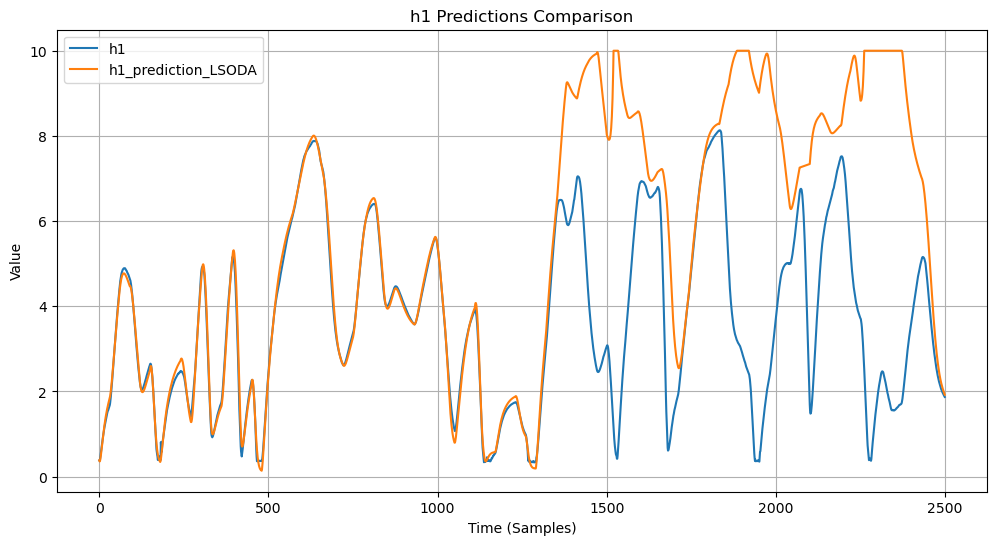

In [10]:
tank1['h1_prediction_Euler'] = h1

# tank1[['h1', 'h1_prediction_LSODA', 'h1_prediction_Euler']].plot(figsize=(12, 6))
tank1[['h1', 'h1_prediction_Euler']].plot(figsize=(12, 6))


plt.title('h1 Predictions Comparison')
plt.xlabel('Time (Samples)')
plt.ylabel('Value')
plt.legend(['h1', 'h1_prediction_LSODA', 'h1_prediction_Euler'])
plt.grid(True)

plt.show()

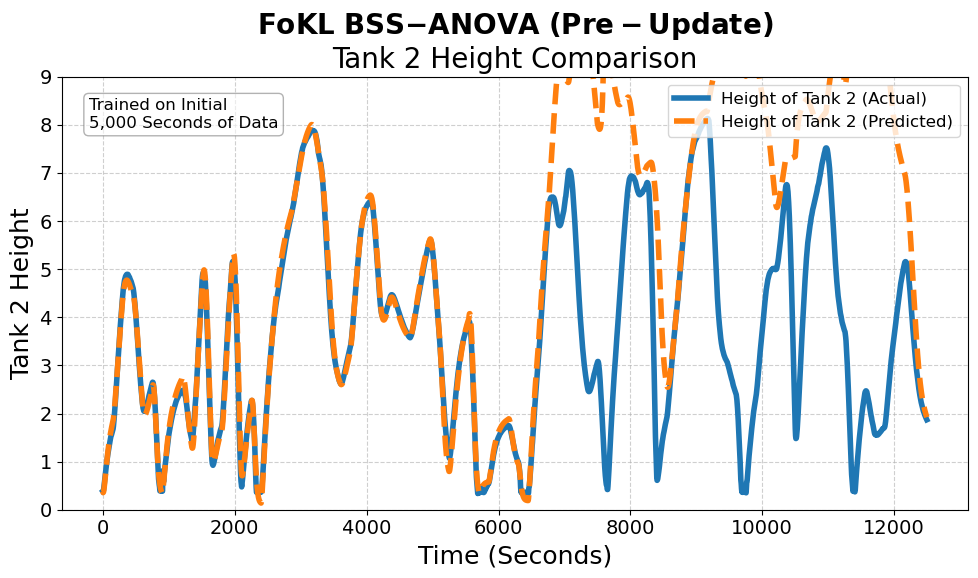

In [11]:
# Plot with improved aesthetics
plt.rcParams.update({'font.size': 14})  # Adjust the number to increase/decrease font size
fig, ax = plt.subplots(figsize=(10, 6))

# Plot both the actual and predicted data
ax.plot(tank1['time'], tank1['h1'], label='h1', linewidth=4, linestyle='-')#, color='blue')
ax.plot(tank1['time'], tank1['h1_prediction_Euler'], label='h1_prediction', linewidth=4, linestyle='--')#, color='red')

# Enhancing the graph with titles, labels, and grid
ax.set_title(r'$\bf{FoKL\ BSS{-}ANOVA\ (Pre-Update)}$' + '\nTank 2 Height Comparison', fontsize=20)
ax.set_xlabel('Time (Seconds)', fontsize=18)
ax.set_ylabel('Tank 2 Height', fontsize=18)
ax.legend(['Height of Tank 2 (Actual)', 'Height of Tank 2 (Predicted)'], fontsize=12, loc='upper right')

ax.grid(True, linestyle='--', alpha=0.6)

# ax.text(-250, 7, 'Trained on Initial \n10,000 Seconds of Data', fontsize=12, color='black', bbox = dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.4', alpha = 0.6))

# Add a note in the upper-left corner with a rounded box
ax.text(0.03, 0.95, 'Trained on Initial \n5,000 Seconds of Data',
        fontsize=12, color='black',
        bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3', alpha = 0.6),
        transform=ax.transAxes,  # Use normalized coordinates
        verticalalignment='top',  # Align text to the top of the box
        horizontalalignment='left')  # Align text to the left

ax.set_ylim(0, 9)

# Show plot
plt.tight_layout()
plt.show()

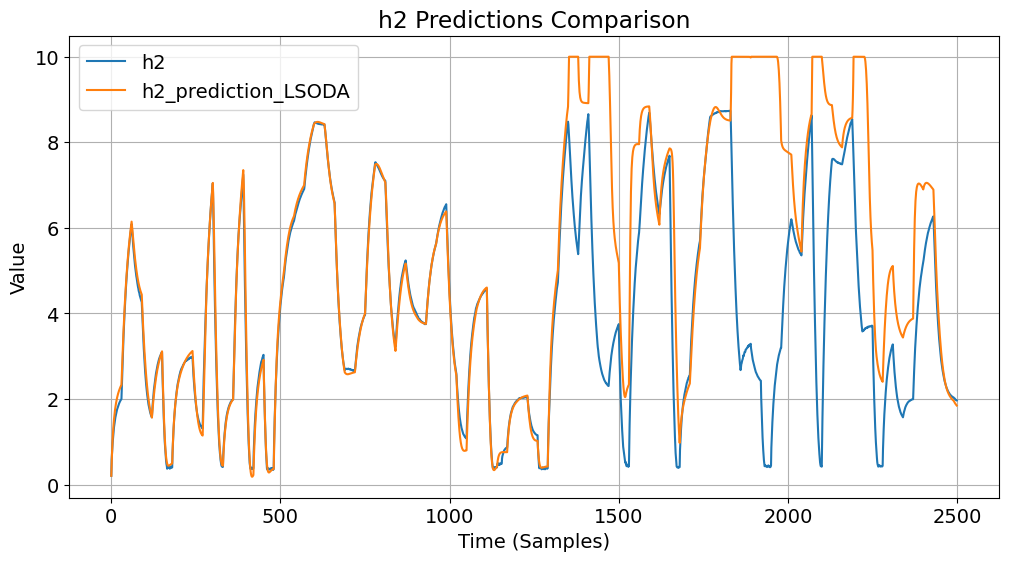

In [12]:
tank1['h2_prediction_Euler'] = h2
# tank1[['h2', 'h2_prediction_LSODA', 'h2_prediction_Euler']].plot(figsize=(12, 6))
tank1[['h2', 'h2_prediction_Euler']].plot(figsize=(12, 6))


plt.title('h2 Predictions Comparison')
plt.xlabel('Time (Samples)')
plt.ylabel('Value')
plt.legend(['h2', 'h2_prediction_LSODA', 'h2_prediction_Euler'])
plt.grid(True)

plt.show()

# Update Model
Now, lets update the model.

In [13]:
# Create Models for the derivatives of h1 and h2
GP_dh1_model1.inputs = GP_dh1_model1.clean(tank1[['h1','h2','u']].iloc[1000:2000].to_numpy().tolist())
data_test = tank1['h1_der'].iloc[1000:2000].to_numpy()
GP_dh1_model1.data = np.expand_dims(data_test, axis = 0).T

# Second fitting
GP_dh1_model1.fit()

# Create Models for the derivatives of h1 and h2
GP_dh2_model1.inputs = GP_dh2_model1.clean(tank1[['h1','h2','u']].iloc[1000:2000].to_numpy().tolist())
data_test = tank1['h2_der'].iloc[1000:2000].to_numpy()
GP_dh2_model1.data = np.expand_dims(data_test, axis = 0).T

# Second fitting
GP_dh2_model1.fit()

# GP_dh1_model1 = FoKLRoutines.FoKL(UserWarnings=False, draws = 500)
# _ = GP_dh1_model1.fit(inputs = [tank1[['h1','h2','u']].iloc[1000:2000]], 
#            data = tank1['h1_der'].iloc[1000:2000], 
#            clean = True,
#         #    pillow = [[0.10,0.30],[0.10,0.30],[0.05,0.10]],
#            update = True,
#            built = True) 

# GP_dh2_model1 = FoKLRoutines.FoKL(UserWarnings=False, draws = 500)
# _ = GP_dh2_model1.fit(inputs = [tank1[['h1','h2','u']].iloc[1000:2000]], 
#            data = tank1['h2_der'].iloc[1000:2000], 
#            clean = True,
#         #    pillow = [[0.10,0.30],[0.10,0.30],[0.05,0.10]],
#            update = True,
#            built = True)

same
4 -10379.249332954423
new
4 -9918.387666078519
new
4 -9989.291876498444
same
5 -9477.247500730111
new
6 -7550.0075373018
new
6 -7510.576975723286


(matrix([[ 0.04516879,  0.13091933,  0.03231272, ..., -0.85395632,
          -0.10737559,  0.2946507 ],
         [ 0.03733402,  0.10999241,  0.0223024 , ..., -0.79869626,
          -0.15868646,  0.18114744],
         [ 0.04957232,  0.15591398, -0.02143049, ..., -0.66298467,
          -0.04541317,  0.11260526],
         ...,
         [ 0.01924825,  0.1377832 , -0.20648119, ..., -0.08594261,
          -0.52600455,  0.15706754],
         [ 0.00606206,  0.10653382, -0.11226122, ...,  0.2836649 ,
          -0.85000514, -0.02181989],
         [ 0.0159277 ,  0.11799453, -0.07682269, ...,  0.0936137 ,
          -0.80914454, -0.24406436]]),
 array([[0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 1.],
        [1., 0., 1.],
        [1., 1., 0.],
        [0., 0., 2.],
        [0., 2., 0.],
        [2., 0., 0.],
        [0., 1., 2.],
        [0., 2., 1.],
        [1., 0., 2.],
        [1., 2., 0.],
        [2., 0., 1.],
        [2., 1., 0.],
        [0., 0., 3.],
        

In [14]:
# Create vector of times and pump signals
tvec = tank1["time"].values
u = tank1['u'].values
# Create blank vectors for h1 and h2 values
h1 = np.zeros_like(tvec, dtype=float)
h2 = np.zeros_like(tvec, dtype=float)

# Initial Conditions
h1[0] = tank1["h1"].values[0]
h2[0] = tank1["h2"].values[0]
# Integration using forward Euler
for i in range(len(tvec) - 1):
    h1[i] = np.clip(h1[i], GP_dh1_model1.minmax[0][0], GP_dh1_model1.minmax[0][1])
    h2[i] = np.clip(h2[i], GP_dh1_model1.minmax[1][0], GP_dh1_model1.minmax[1][1])
    h1[i + 1] = h1[i] + 5 * GP_dh1_model1.evaluate([h1[i], h2[i], u[i]], clean=True, SingleInstance=True)
    h2[i + 1] = h2[i] + 5 * GP_dh2_model1.evaluate([h1[i], h2[i], u[i]], clean=True, SingleInstance=True)
    
    if i % 250 == 0:
        print(i)

tank1['h1_prediction_Euler'] = h1
tank1['h2_prediction_Euler'] = h2

0


C:\Users\Michael\AppData\Local\Temp\ipykernel_21692\3283254062.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  h1[i + 1] = h1[i] + 5 * GP_dh1_model1.evaluate([h1[i], h2[i], u[i]], clean=True, SingleInstance=True)
C:\Users\Michael\AppData\Local\Temp\ipykernel_21692\3283254062.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  h2[i + 1] = h2[i] + 5 * GP_dh2_model1.evaluate([h1[i], h2[i], u[i]], clean=True, SingleInstance=True)


250
500
750
1000
1250
1500
1750
2000
2250


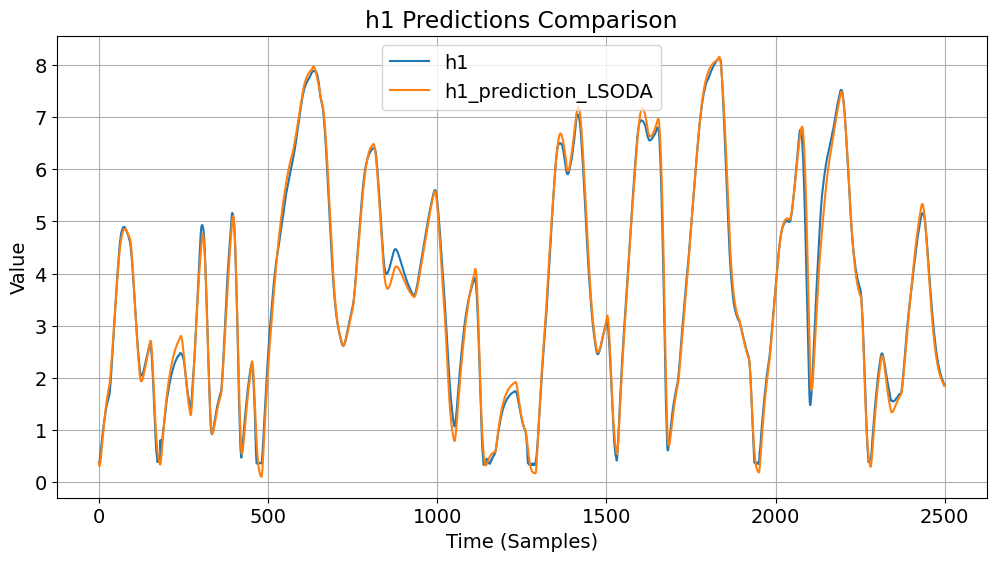

In [15]:
tank1['h1_prediction_Euler'] = h1

# tank1[['h1', 'h1_prediction_LSODA', 'h1_prediction_Euler']].plot(figsize=(12, 6))
tank1[['h1', 'h1_prediction_Euler']].plot(figsize=(12, 6))


plt.title('h1 Predictions Comparison')
plt.xlabel('Time (Samples)')
plt.ylabel('Value')
plt.legend(['h1', 'h1_prediction_LSODA', 'h1_prediction_Euler'])
plt.grid(True)

plt.show()

In [16]:
MSE = np.sum((tank1['h1'][2000:-1] - tank1['h1_prediction_Euler'][2000:-1])**2)/len(tank1)
MSE

0.015599954833874441

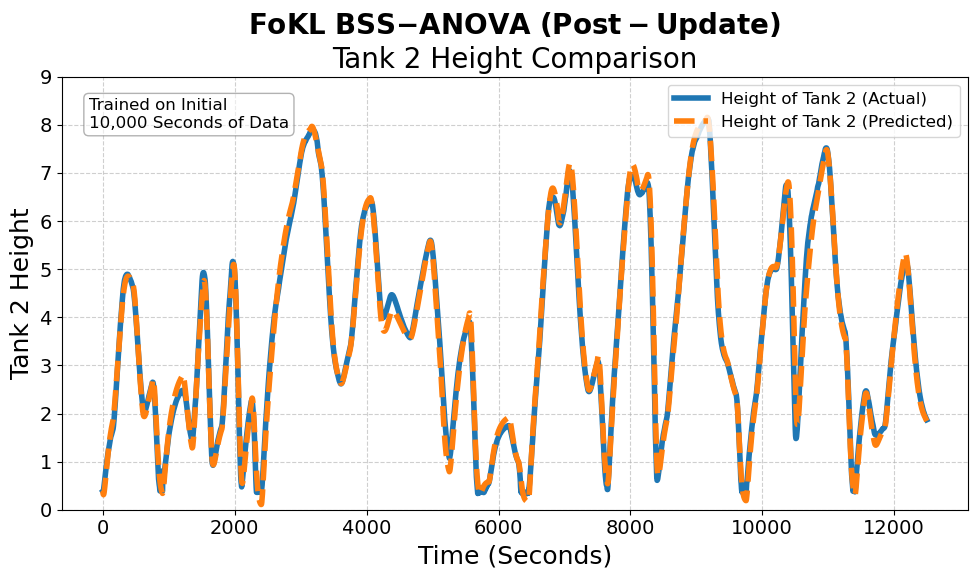

In [17]:
# Plot with improved aesthetics
plt.rcParams.update({'font.size': 14})  # Adjust the number to increase/decrease font size
fig, ax = plt.subplots(figsize=(10, 6))

# Plot both the actual and predicted data
ax.plot(tank1['time'], tank1['h1'], label='h1', linewidth=4, linestyle='-')#, color='blue')
ax.plot(tank1['time'], tank1['h1_prediction_Euler'], label='h1_prediction', linewidth=4, linestyle='--')#, color='red')

# Enhancing the graph with titles, labels, and grid
ax.set_title(r'$\bf{FoKL\ BSS{-}ANOVA\ (Post-Update)}$' + '\nTank 2 Height Comparison', fontsize=20)
ax.set_xlabel('Time (Seconds)', fontsize=18)
ax.set_ylabel('Tank 2 Height', fontsize=18)
ax.legend(['Height of Tank 2 (Actual)', 'Height of Tank 2 (Predicted)'], fontsize=12, loc='upper right')

ax.grid(True, linestyle='--', alpha=0.6)

# ax.text(-250, 7, 'Trained on Initial \n10,000 Seconds of Data', fontsize=12, color='black', bbox = dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.4', alpha = 0.6))

# Add a note in the upper-left corner with a rounded box
ax.text(0.03, 0.95, 'Trained on Initial \n10,000 Seconds of Data',
        fontsize=12, color='black',
        bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3', alpha = 0.6),
        transform=ax.transAxes,  # Use normalized coordinates
        verticalalignment='top',  # Align text to the top of the box
        horizontalalignment='left')  # Align text to the left

ax.set_ylim(0, 9)

# Show plot
plt.tight_layout()
plt.show()

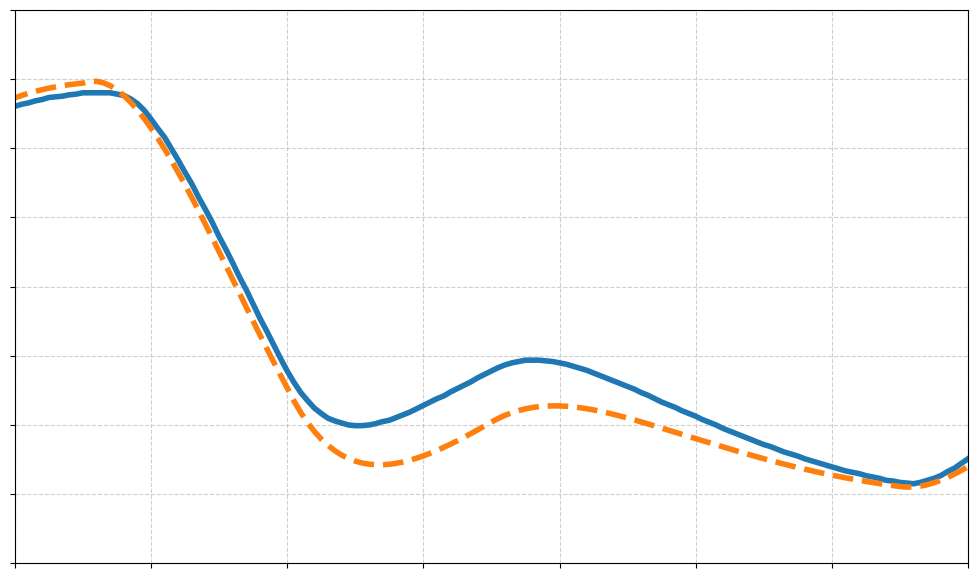

In [26]:
# Plot with improved aesthetics
plt.rcParams.update({'font.size': 14})  # Adjust the number to increase/decrease font size
fig, ax = plt.subplots(figsize=(10, 6))

# Plot both the actual and predicted data
ax.plot(tank1['time'], tank1['h1'], label='h1', linewidth=4, linestyle='-')#, color='blue')
ax.plot(tank1['time'], tank1['h1_prediction_Euler'], label='h1_prediction', linewidth=4, linestyle='--')#, color='red')

# Enhancing the graph with titles, labels, and grid
# ax.set_title(r'$\bf{FoKL\ BSS{-}ANOVA\ (Post-Update)}$' + '\nTank 2 Height Comparison', fontsize=20)
# ax.set_xlabel('Time (Seconds)', fontsize=18)
# ax.set_ylabel('Tank 2 Height', fontsize=18)
# ax.legend(['Height of Tank 2 (Actual)', 'Height of Tank 2 (Predicted)'], fontsize=12, loc='upper right')

ax.grid(True, linestyle='--', alpha=0.6)

# ax.text(-250, 7, 'Trained on Initial \n10,000 Seconds of Data', fontsize=12, color='black', bbox = dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.4', alpha = 0.6))

# Add a note in the upper-left corner with a rounded box
# ax.text(0.03, 0.95, 'Trained on Initial \n10,000 Seconds of Data',
#         fontsize=12, color='black',
#         bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3', alpha = 0.6),
#         transform=ax.transAxes,  # Use normalized coordinates
#         verticalalignment='top',  # Align text to the top of the box
#         horizontalalignment='left')  # Align text to the left

ax.set_ylim(3, 7)
ax.set_xlim(4000,4700)

# Turn on grid
ax.grid(True)

# Remove the x and y axis labels
ax.set_xlabel('')
ax.set_ylabel('')

# Optionally, if you want to remove the tick labels as well, use:
ax.set_xticklabels([])
ax.set_yticklabels([])

# Show plot
plt.tight_layout()
plt.show()

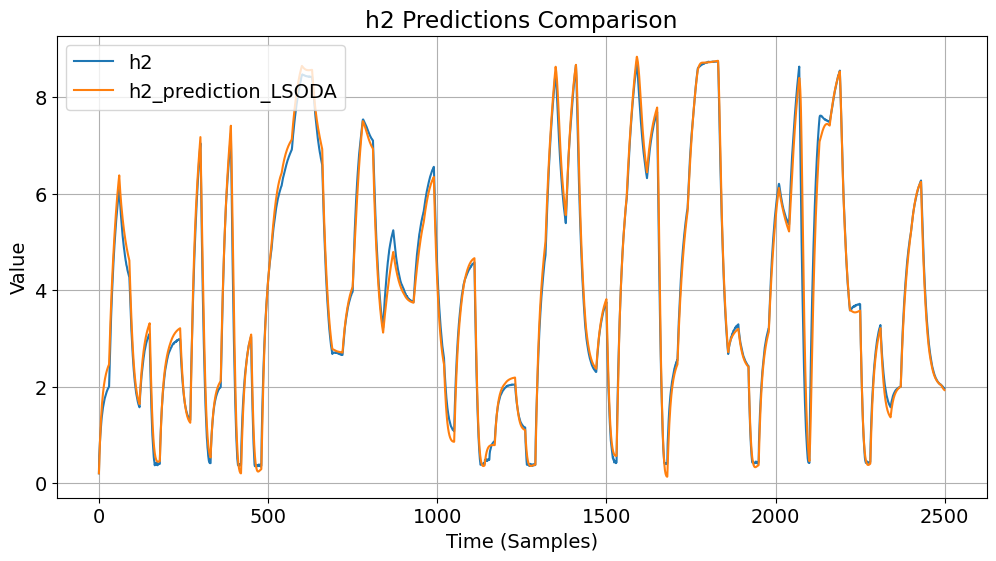

In [18]:
tank1['h2_prediction_Euler'] = h2
# tank1[['h2', 'h2_prediction_LSODA', 'h2_prediction_Euler']].plot(figsize=(12, 6))
tank1[['h2', 'h2_prediction_Euler']].plot(figsize=(12, 6))


plt.title('h2 Predictions Comparison')
plt.xlabel('Time (Samples)')
plt.ylabel('Value')
plt.legend(['h2', 'h2_prediction_LSODA', 'h2_prediction_Euler'])
plt.grid(True)

plt.show()